# Capstone Project - The Battle of Neighborhoods (Week 2)

## 1. Import all Libraries

In [1]:
!pip install geocoder
!pip install folium

In [2]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


## 2. Data Extraction and Cleaning:

In [3]:
# download url data from internet
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(url).text
data_can = BeautifulSoup(source, 'lxml')

In [4]:
# creat a new Dataframe
column_names = ['Postalcode','Borough','Neighborhood']
data_to = pd.DataFrame(columns = column_names)

In [5]:
content = data_can.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    data_to = data_to.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood}, ignore_index=True)

# clean dataframe 
data_to = data_to[data_to.Borough!='Not assigned']
data_to = data_to[data_to.Borough!= 0]
data_to.reset_index(drop = True, inplace = True)
i = 0
for i in range(0, data_to.shape[0]):
    if data_to.iloc[i][2] == 'Not assigned':
        data_to.iloc[i][2] = data_to.iloc[i][1]
        i = i+1
                                 
df = data_to.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [6]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [7]:
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df1 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [9]:
df1.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,10,103
top,M5X,North York,York Mills West
freq,1,24,1


In [10]:
#display the top 10 rows
print(df1.shape)
df1.head(10)

(103, 3)


,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [11]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.70949500000006, -79.36398897099997]

In [12]:
# Retrieving Postal Code Co-ordinates
postal_codes = df1['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [13]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df1['Latitude'] = df_coords['Latitude']
df1['Longitude'] = df_coords['Longitude']

In [14]:
df1[df1.Postalcode == 'M5G']

,Postalcode,Borough,Neighborhood,Latitude,Longitude
57,M5G,Downtown Toronto,Central Bay Street,43.656091,-79.38493


In [15]:
df1.head(10)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.811525,-79.195517
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.785665,-79.158725
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765815,-79.175193
3,M1G,Scarborough,Woburn,43.768369,-79.217590
4,M1H,Scarborough,Cedarbrae,43.769688,-79.239440
5,M1J,Scarborough,Scarborough Village,43.743125,-79.231750
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.726276,-79.263625
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.713054,-79.285055
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.724235,-79.227925
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.696770,-79.259967


In [16]:
address = 'Scarborough,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Seattle,Washington are 43.773077, -79.257774.


## 3. Map of Scarborough

In [17]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df1['Latitude'], df1['Longitude'], df1['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [18]:
address = 'Scarborough,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.773077, -79.257774.


In [19]:
# @hiddel_cell
CLIENT_ID = 'FTHMZXKABZASYXN0GIFXBUVGXDTWE25VLDRTWO22ROZJCGHB' # my Foursquare ID
CLIENT_SECRET = 'BKWHMA3CK032GRZ31JLOEXMZSR2VV4QB1TVZBA5IU443Y4GQ' # my Foursquare Secret
VERSION = '20200313'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: FTHMZXKABZASYXN0GIFXBUVGXDTWE25VLDRTWO22ROZJCGHB
CLIENT_SECRET: BKWHMA3CK032GRZ31JLOEXMZSR2VV4QB1TVZBA5IU443Y4GQ


In [20]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [21]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.events.count', 'venue.events.summary', 'venue.id',
       'venue.location.address', 'venue.location.cc', 'venue.location.city',
       'venue.location.country', 'venue.location.crossStreet',
       'venue.location.distance', 'venue.location.formattedAddress',
       'venue.location.labeledLatLngs', 'venue.location.lat',
       'venue.location.lng', 'venue.location.neighborhood',
       'venue.location.postalCode', 'venue.location.state', 'venue.name',
       'venue.photos.count', 'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [22]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## 4. Nearby Venues/Locations


In [23]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head(10)

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
1,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
2,American Eagle Outfitters,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334
3,St. Andrews Fish & Chips,"[{'id': '4edd64a0c7ddd24ca188df1a', 'name': 'F...",43.771865,-79.252645
4,Canyon Creek Chophouse,"[{'id': '4bf58dd8d48988d1cc941735', 'name': 'S...",43.776959,-79.261694
5,Tommy Hilfiger,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776015,-79.257369
6,DAVIDsTEA,"[{'id': '4bf58dd8d48988d1dc931735', 'name': 'T...",43.776320,-79.258688
7,Shoppers Drug Mart,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",43.773305,-79.251662
8,Chipotle Mexican Grill,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",43.776410,-79.258069
9,Tim Hortons,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.769936,-79.260368


## 5. Categories of Nearby Venues/Locations

In [24]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

,name,categories,lat,lng
0,Disney Store,Toy / Game Store,43.775537,-79.256833
1,SEPHORA,Cosmetics Shop,43.775017,-79.258109
2,American Eagle Outfitters,Clothing Store,43.776012,-79.258334
3,St. Andrews Fish & Chips,Fish & Chips Shop,43.771865,-79.252645
4,Canyon Creek Chophouse,Steakhouse,43.776959,-79.261694
5,Tommy Hilfiger,Clothing Store,43.776015,-79.257369
6,DAVIDsTEA,Tea Room,43.776320,-79.258688
7,Shoppers Drug Mart,Pharmacy,43.773305,-79.251662
8,Chipotle Mexican Grill,Mexican Restaurant,43.776410,-79.258069
9,Tim Hortons,Coffee Shop,43.769936,-79.260368


In [25]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store      8
Coffee Shop         5
Restaurant          3
Cosmetics Shop      3
Tea Room            2
Sandwich Place      2
Pharmacy            2
Gas Station         2
Food Court          2
Department Store    1
Name: categories, dtype: int64

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df1['Neighborhood'],
                                   latitudes=df1['Latitude'],
                                   longitudes=df1['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [30]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head(10)

There are 303 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,27,27,27,27,27,27
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",2,2,2,2,2,2
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",15,15,15,15,15,15
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Downsview North, Wilson Heights",12,12,12,12,12,12
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",28,28,28,28,28,28
Berczy Park,100,100,100,100,100,100


## 6.One Hot Encoding of Features

In [31]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head()

,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,T

In [32]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Adelaide, King, Richmond ----
         venue  freq
0         Café  0.07
1   Restaurant  0.07
2  Coffee Shop  0.07
3        Hotel  0.05
4    Gastropub  0.03


---- Agincourt ----
                      venue  freq
0        Chinese Restaurant  0.11
1             Shopping Mall  0.07
2               Pizza Place  0.07
3  Mediterranean Restaurant  0.04
4        Seafood Restaurant  0.04


---- Agincourt North, L'Amoreaux East, Milliken, Steeles East ----
            venue  freq
0  Sandwich Place   0.5
1        Pharmacy   0.5
2   Moving Target   0.0
3    Noodle House   0.0
4       Nightclub   0.0


---- Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown ----
                  venue  freq
0         Grocery Store  0.13
1           Auto Garage  0.07
2        Hardware Store  0.07
3  Fast Food Restaurant  0.07
4                  Park  0.07


---- Alderwood, Long Branch ----
         venue  freq
0         Pool  0.11
1          Pub  0.11


                        venue  freq
0                Home Service  0.29
1           Convenience Store  0.14
2  Construction & Landscaping  0.14
3      Furniture / Home Store  0.14
4                      Bakery  0.14


---- East Birchmount Park, Ionview, Kennedy Park ----
               venue  freq
0  Convenience Store  0.29
1     Discount Store  0.29
2         Hobby Shop  0.14
3   Department Store  0.14
4        Coffee Shop  0.14


---- East Toronto ----
                venue  freq
0  Athletics & Sports  0.17
1            Bus Line  0.17
2         Coffee Shop  0.17
3                Park  0.17
4  Italian Restaurant  0.17


---- Emery, Humberlea ----
                       venue  freq
0                Coffee Shop  0.29
1  Latin American Restaurant  0.14
2                  Nightclub  0.14
3             Discount Store  0.14
4                       Café  0.14


---- Fairview, Henry Farm, Oriole ----
                  venue  freq
0        Clothing Store  0.11
1           Coffee Shop  0.07
2  

                        venue  freq
0  Construction & Landscaping   0.4
1                 Zoo Exhibit   0.2
2                Climbing Gym   0.2
3        Fast Food Restaurant   0.2
4                 Music Venue   0.0


---- Runnymede, Swansea ----
              venue  freq
0              Café  0.08
1       Coffee Shop  0.08
2       Pizza Place  0.05
3            Bakery  0.05
4  Sushi Restaurant  0.05


---- Ryerson, Garden District ----
                       venue  freq
0                Coffee Shop  0.11
1             Clothing Store  0.05
2                 Restaurant  0.04
3  Middle Eastern Restaurant  0.04
4            Bubble Tea Shop  0.02


---- Scarborough Village ----
               venue  freq
0     Ice Cream Shop  0.22
1     Sandwich Place  0.22
2      Big Box Store  0.11
3  Indian Restaurant  0.11
4         Restaurant  0.11


---- Silver Hills, York Mills ----
          venue  freq
0          Park   1.0
1   Zoo Exhibit   0.0
2        Museum   0.0
3  Noodle House   0.0
4     Nig

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## 7.Most Common venues near neighborhood

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Restaurant,Café,Hotel,Breakfast Spot,Seafood Restaurant,Gastropub,Steakhouse,Gym,Sushi Restaurant
1,Agincourt,Chinese Restaurant,Pizza Place,Shopping Mall,Pool,Malay Restaurant,Breakfast Spot,Coffee Shop,Japanese Restaurant,Bank,Bakery
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Pharmacy,Sandwich Place,Yoga Studio,Event Space,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Beer Store,Japanese Restaurant,Auto Garage,Caribbean Restaurant,Gym Pool,Park,Hardware Store,Discount Store,Sandwich Place
4,"Alderwood, Long Branch",Pizza Place,Pool,Sandwich Place,Coffee Shop,Gym,Print Shop,Pub,Pharmacy,Gas Station,Event Space


## 8.K-Means Clustering Approach

In [35]:
# Using K-Means to cluster neighborhood into 3 clusters
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [36]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged = df1.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()# check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.811525,-79.195517,2,Construction & Landscaping,Climbing Gym,Fast Food Restaurant,Zoo Exhibit,African Restaurant,Food Court,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.785665,-79.158725,0,Moving Target,History Museum,Bar,Yoga Studio,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765815,-79.175193,1,Park,Gym / Fitness Center,Athletics & Sports,Yoga Studio,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
3,M1G,Scarborough,Woburn,43.768369,-79.217590,0,Coffee Shop,Park,Fast Food Restaurant,Business Service,Falafel Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
4,M1H,Scarborough,Cedarbrae,43.769688,-79.239440,0,Flower Shop,Indian Restaurant,Bank,Thai Restaurant,Bakery,Caribbean Restaurant,Hakka Restaurant,Gas Station,Athletics & Sports,Farm


## 9. Map of Clusters

In [37]:
kclusters = 10

In [38]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [39]:
dataf1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
dataf2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
dataf3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [40]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df1["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

In [41]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

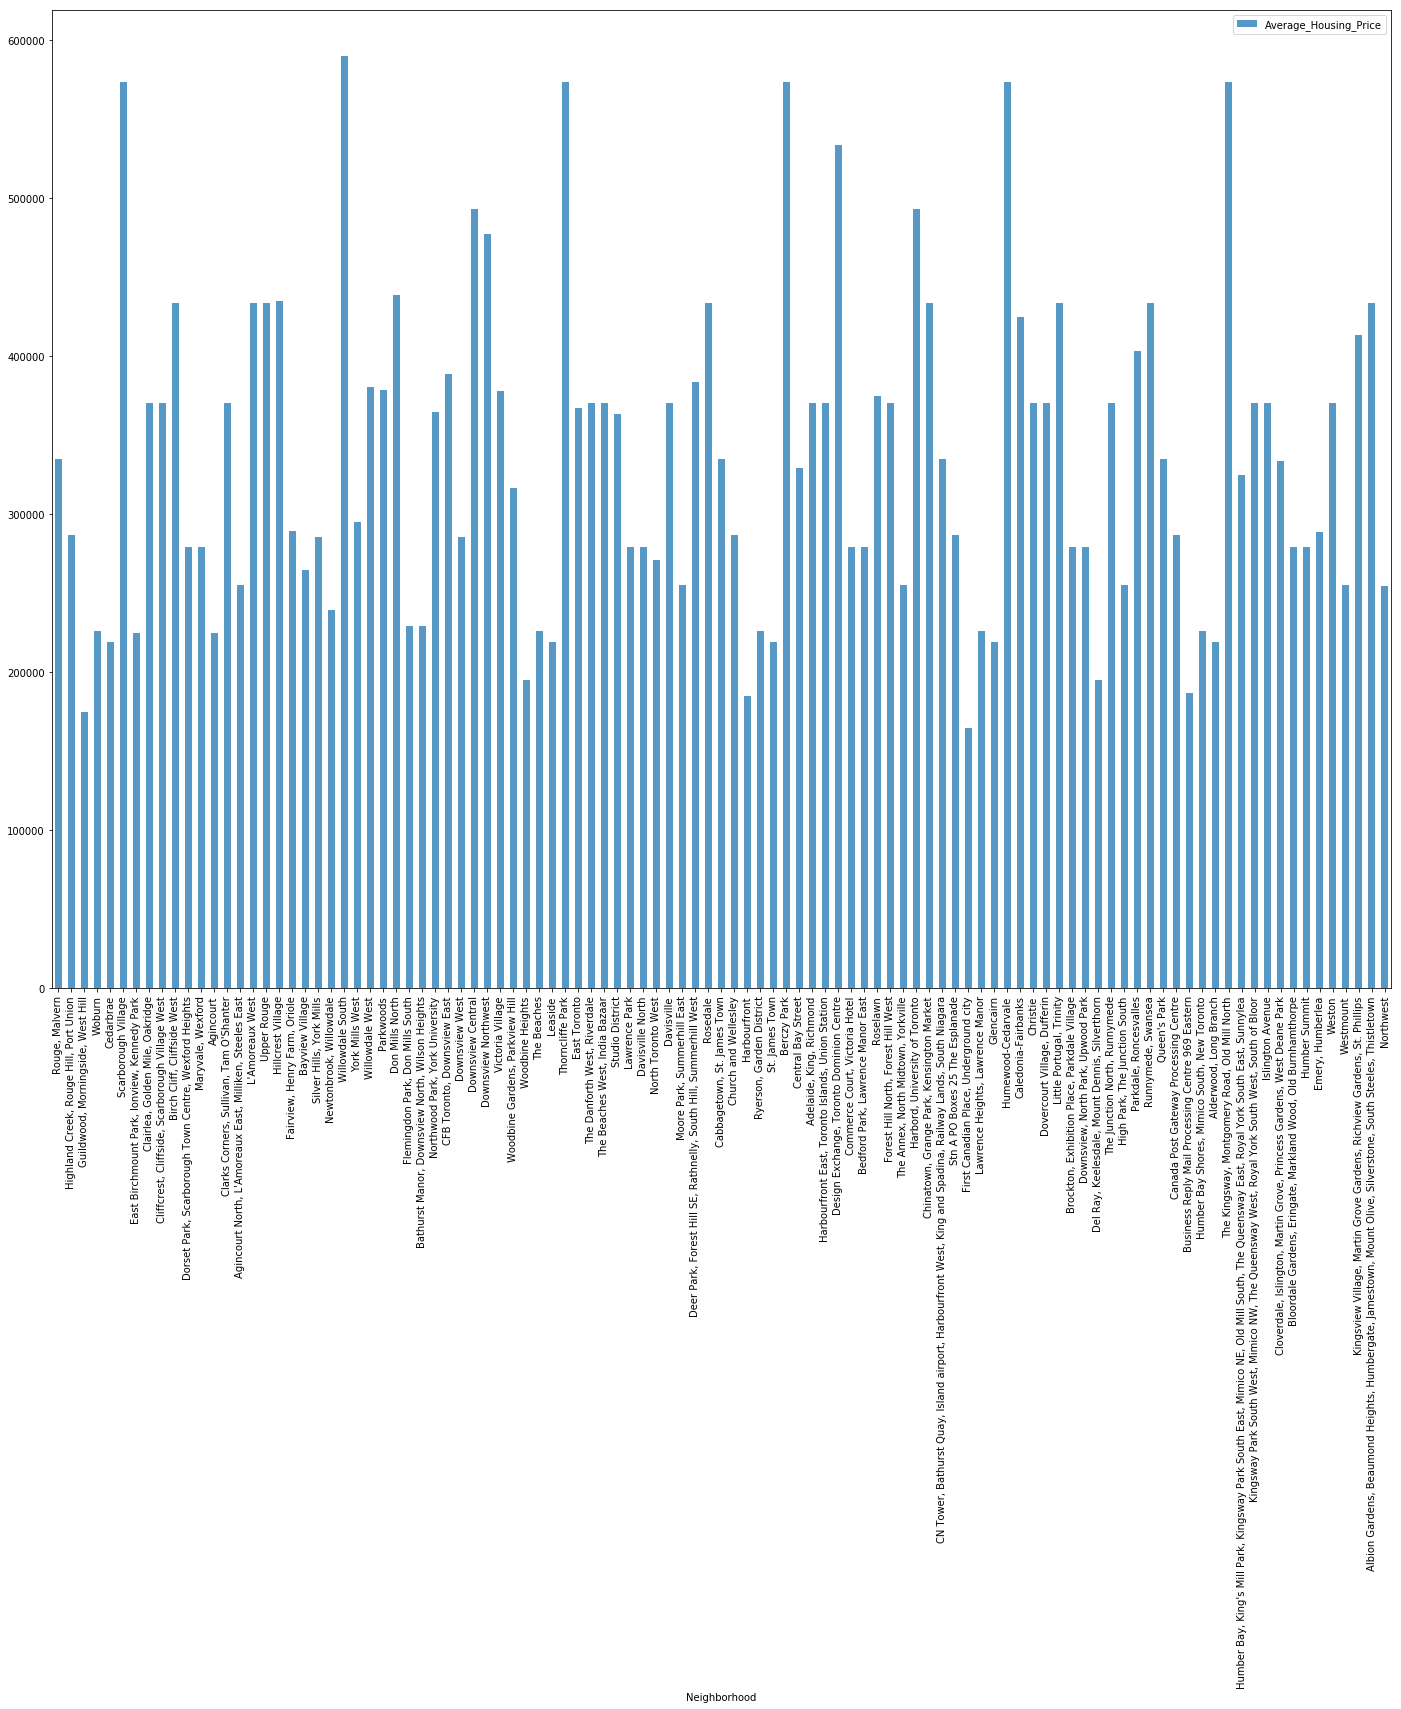

In [42]:
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

## 10.School Rating by Clusters

In [43]:
clusters=pd.DataFrame({"Cluster1":dataf1["Neighborhood"],
                      "Cluster2":dataf2["Neighborhood"],
                      "Cluster4":dataf3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [44]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [45]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

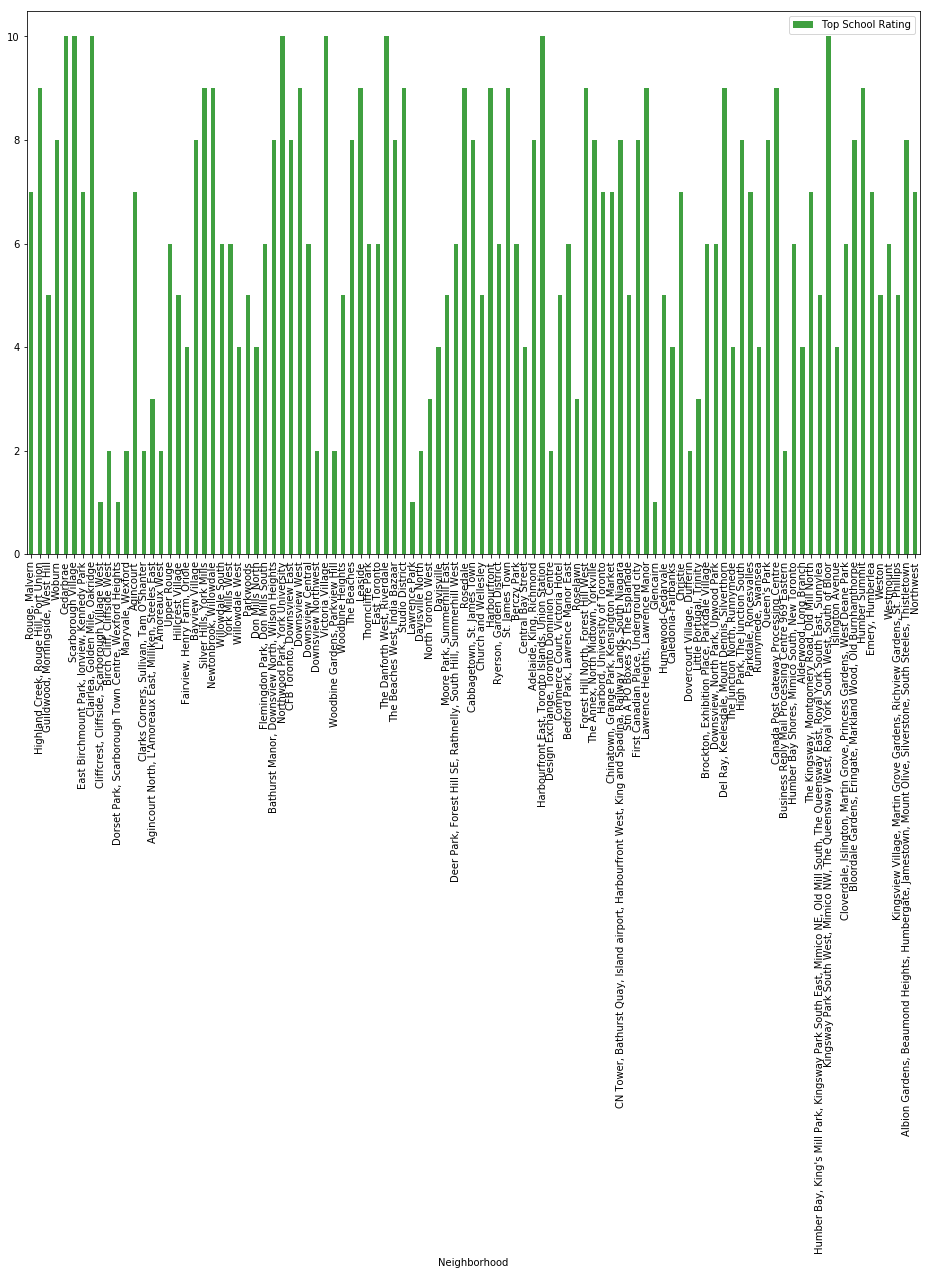

In [46]:
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);

**Conclusion:** In this project, using k-means cluster algorithm I separated the neighborhood into 10(Ten) different clusters and for 103 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.